In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# Cell 2: Data Preparation Function
def prepare_time_series_features(df):
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y')
    
    # Extract time-based features
    df['year'] = df['date'].dt.year
    df['month'] = 6  # Mid-year as default for annual data
    df['day'] = 15   # Mid-month as default
    df['day_of_week'] = 3  # Mid-week as default
    df['quarter'] = 2  # Mid-year quarter
    df['is_year_start'] = (df['date'].dt.month == 1).astype(int)
    df['is_year_end'] = (df['date'].dt.month == 12).astype(int)
    
    # Lag features
    df['gdp_lag1'] = df['Real GDP'].shift(1)
    df['gdp_lag2'] = df['Real GDP'].shift(2)
    
    # Rolling window features
    df['gdp_rolling_mean_3'] = df['Real GDP'].rolling(window=3, min_periods=1).mean()
    df['gdp_rolling_std_3'] = df['Real GDP'].rolling(window=3, min_periods=1).std()
    
    return df

## importing dataset

In [3]:
df = pd.read_excel("PetrolConsumptionGDPReal.xlsx", sheet_name="Sheet1")
df.head()

,date,Actual MS 1980-2023,Real GDP
0,1980,542254.0,204617.825536
1,1981,589017.0,217716.910084
2,1982,644907.0,219620.869640
3,1983,690214.0,195215.358025
4,1984,754725.0,190998.787568


In [4]:
df = prepare_time_series_features(df)

In [6]:
df.head()

,date,Actual MS 1980-2023,Real GDP,year,month,day,day_of_week,quarter,is_year_start,is_year_end,gdp_lag1,gdp_lag2,gdp_rolling_mean_3,gdp_rolling_std_3
0,1980-01-01,542254.0,204617.825536,1980,6,15,3,2,1,0,NaN,NaN,204617.825536,NaN
1,1981-01-01,589017.0,217716.910084,1981,6,15,3,2,1,0,204617.825536,NaN,211167.367810,9262.451511
2,1982-01-01,644907.0,219620.869640,1982,6,15,3,2,1,0,217716.910084,204617.825536,213985.201753,8168.051689
3,1983-01-01,690214.0,195215.358025,1983,6,15,3,2,1,0,219620.869640,217716.910084,210851.045916,13574.325669
4,1984-01-01,754725.0,190998.787568,1984,6,15,3,2,1,0,195215.358025,219620.869640,201945.005078,15452.249274


In [9]:
# Cell 4: Feature and Target Preparation
def prepare_model_data(df):
    # Separate known and missing data
    known_data = df[df['Actual MS 1980-2023'].notna()]
    missing_data = df[df['Actual MS 1980-2023'].isna()]
    
    # Select features
    features = ['year', 'month', 'day', 'day_of_week', 'quarter', 
                'is_year_start', 'is_year_end', 'Real GDP', 
                'gdp_lag1', 'gdp_lag2', 
                'gdp_rolling_mean_3', 'gdp_rolling_std_3']
    
    X = known_data[features]
    y = known_data['Actual MS 1980-2023']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, known_data, missing_data, features

# Prepare data
X_train, X_test, y_train, y_test, known_data, missing_data, features = prepare_model_data(df)

In [10]:
# Cell 5: XGBoost Model Training
def train_xgboost_model(X_train, y_train):
    # Define best parameters
    best_params = {
        'n_estimators': 200,
        'learning_rate': 0.1,
        'max_depth': 3,
        'colsample_bytree': 0.5,
        'random_state': 42
    }
    
    # Create and train model
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train)
    
    return model

# Train the model
model = train_xgboost_model(X_train, y_train)

In [11]:
# Cell 6: Model Evaluation
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print("Model Performance Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Percentage Error: {mape}%")
    
    return y_pred

# Evaluate the model
y_pred = evaluate_model(model, X_test, y_test)

Model Performance Metrics:
Mean Squared Error: 1112192697214.3682
Mean Absolute Error: 778376.4166666666
Root Mean Squared Error: 1054605.4699338365
Mean Absolute Percentage Error: 31.75716284523587%


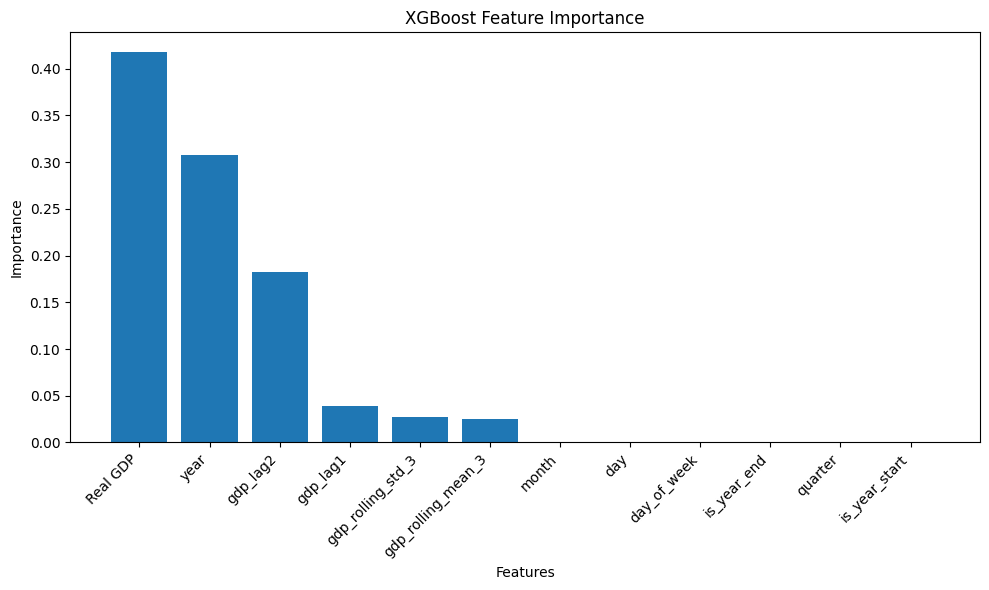

In [14]:
# Cell 7: Feature Importance Visualization
def plot_feature_importance(model, features):
    # Get feature importances
    importance = model.feature_importances_
    
    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance(model, features)

In [13]:
# Cell 8: Forecasting Missing Values
def forecast_missing_values(model, missing_data, features):
    X_missing = missing_data[features]
    forecasted_values = model.predict(X_missing)
    
    # Update missing data with forecasted values
    missing_data['Forecasted MS'] = forecasted_values
    
    return missing_data

# Forecast missing values
forecasted_data = forecast_missing_values(model, missing_data, features)
print(forecasted_data[['date', 'Real GDP', 'Forecasted MS']])

C:\Users\MoaviaHassan\AppData\Local\Temp\ipykernel_2164\3994029920.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['Forecasted MS'] = forecasted_values


         date      Real GDP  Forecasted MS
44 2024-01-01  60186.914062      7643935.5
45 2025-01-01  63374.964844      8284553.0
46 2026-01-01  62550.007812      8119838.5
47 2027-01-01  65516.738281      8119838.5
48 2028-01-01  64598.535156      8119838.5
49 2029-01-01  63254.734375      8119838.5
50 2030-01-01  63719.175781      8119838.5
51 2031-01-01  64197.585938      8119838.5
52 2032-01-01  62614.535156      8119838.5
53 2033-01-01  65185.175781      8119838.5
54 2034-01-01  67353.601562      8284412.0
55 2035-01-01  67583.726562      8119838.5
56 2036-01-01  66011.367188      8119838.5
57 2037-01-01  66094.601562      8119838.5
58 2038-01-01  69756.031250      8308784.0
